# Mie scattering from PMDI droplets

This program estimates light scattering from spherical droplets to approximate optical PMDI experiments.
    
    @author Daniel Duke <daniel.duke@monash.edu>
    @copyright (c) 2020 LTRAC
    @license GPL-3.0+
    @version 0.0.1
    @date 06/05/2020
        __   ____________    ___    ______
       / /  /_  ____ __  \  /   |  / ____/
      / /    / /   / /_/ / / /| | / /
     / /___ / /   / _, _/ / ___ |/ /_________
    /_____//_/   /_/ |__\/_/  |_|\__________/

    Laboratory for Turbulence Research in Aerospace & Combustion (LTRAC)
    Monash University, Australia


In [1]:
# Load modules
import numpy as np
import scipy.special 
import matplotlib.pyplot as plt
%matplotlib notebook

In [70]:
# Absorption and Scattering of Light by Small Particles
# (Book by Craig Bohren and Donald Huffman)
# Ch6. SCATTERING BY AN ISOTROPIC, HOMOGENEOUS SPHERE.



# Mie coefficients a_n, b_n
# n is the summation series index
# m is complex refractive index
# x is the size parameter
# rbvals are Ricatti-Bessel functions pre-evaluated.
def mie_coeffs(n, m, x, rbvals):
    
    jn, jnp, jm, jmp, yn, ynp = rbvals
    
    # Logarithmic derivative (d/dx)ln(Psi_n(m*x))
    # using chain rule, this is Psi'_n(m*x)/Psi_n(m*x)
    logderiv = jmp[n]/complex(jm[n])
    
    # Evaluate A
    A = ((logderiv/complex(m)) + (n/complex(x)))
    a_numr = A*jn[n] - jn[n-1] #A*ricattiBesselPsi(x,n) - ricattiBesselPsi(x,n-1)
    a_deno = A*yn[n] - yn[n-1] #A*ricattiBesselXi(x,n) - ricattiBesselXi(x,n-1)
    a_deno += 1e-99
    
    # Evaluate B
    B = ((m*logderiv/complex(m)) + (n/complex(x)))
    b_numr = B*jn[n] - jn[n-1] #B*ricattiBesselPsi(x,n) - ricattiBesselPsi(x,n-1)
    b_deno = B*yn[n] - yn[n-1] #B*ricattiBesselXi(x,n) - ricattiBesselXi(x,n-1)
    b_deno += 1e-99
    
    return a_numr/a_deno, b_numr/b_deno


# Extinction & Scattering cross sections
# r is the radius of the scattering sphere.
# k is the wavenumber of incident light
# m is complex refractive index of the sphere relative to the surroundings
# n_max is the number of terms in the infinite series to compute
def CrossSections(k,m,r,n_max=12):

    # Enforce a complex refractive index for type matching
    m = complex(m)
    
    # Size parameter
    x = k*r
    
    # Calculate Riccati-Bessel functions up to n_max
    jn, jnp = scipy.special.riccati_jn(n_max,x)   # Psi_n(x)
    jm, jmp = scipy.special.riccati_jn(n_max,m*x) # Psi_n(m*x)
    yn, ynp = scipy.special.riccati_yn(n_max,x)   # Xi_n(x)
    rbvals = (jn, jnp, jm, jmp, yn, ynp)
    
    # Loop summation series
    s_ext = 0
    s_sca = 0
    for n in range(1,n_max+1):
        an, bn = mie_coeffs(n,m,x,rbvals)
        s_ext += (2*n+1)*np.real(an + bn)
        s_sca += (2*n+1)*(np.abs(an)**2 + np.abs(bn)**2)
    s_ext *= 2 * np.pi / (k**2 + 1e-99)
    s_sca *= 2 * np.pi / (k**2 + 1e-99)
    return np.abs(s_ext), np.abs(s_sca)

# Rayleigh scattering cross section - proportional only
def Rayleigh(k,r):
    lam=2*np.pi/float(k)
    vol=(4/3.)*np.pi*(r**3)
    return (vol**2) / (lam**4)

<IPython.core.display.Javascript object>


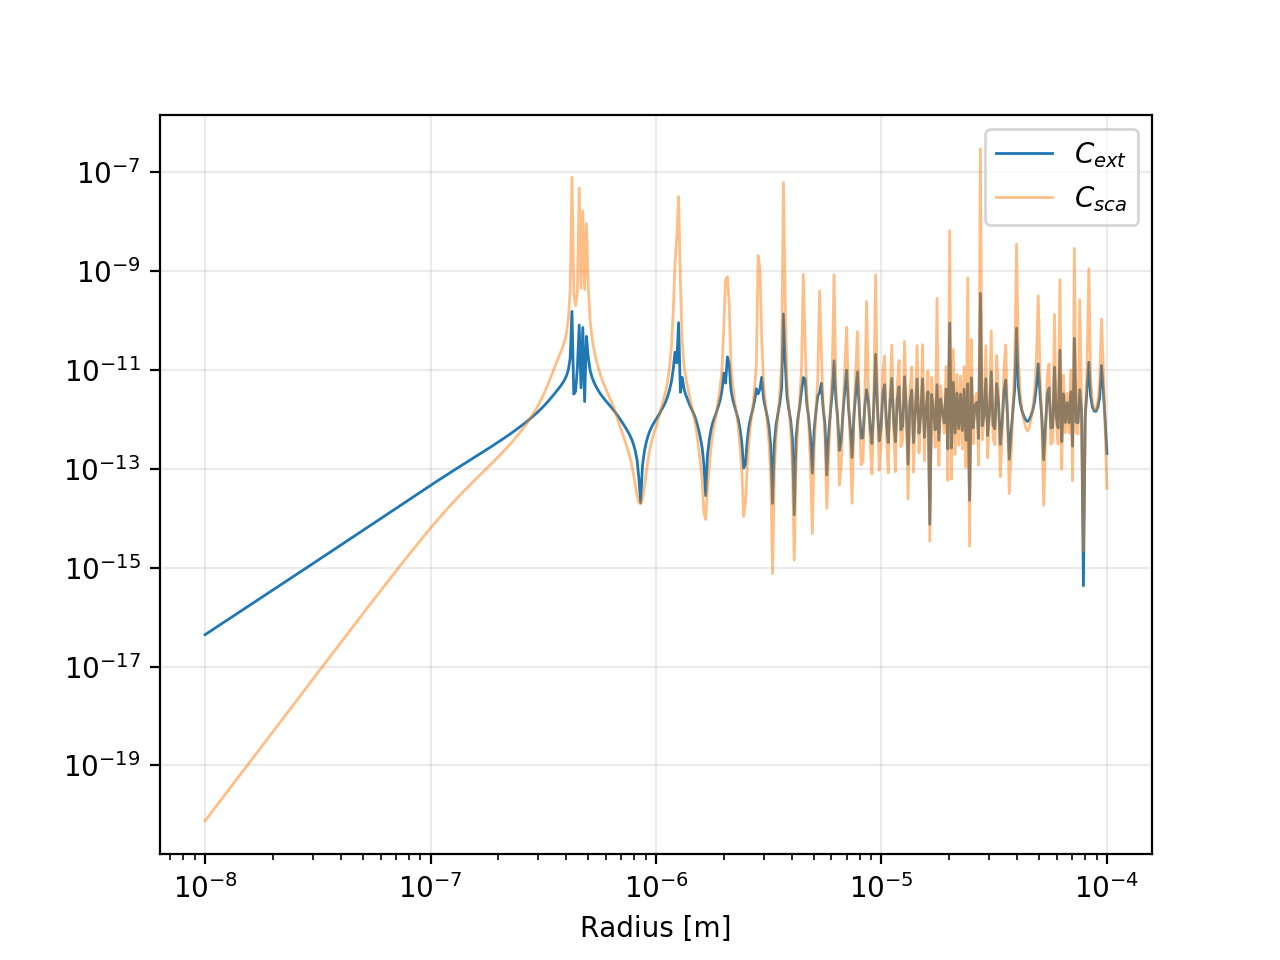

In [71]:
# testing - constants
lam = 550.0e-9
k = 2*np.pi/lam
m = 1.33560 + 2.47e-09j  # water in air at 550nm
radii = np.logspace(-8,-4,500)



# result is shape [n_max,2] with C_ext and C_scatt. in each column.
result = np.array([ CrossSections(k,m,r,n_max=3) for r in radii ])

# plot
fig=plt.figure()
ax=fig.add_subplot(111)
plt.xlabel('Radius [m]')
plt.grid(alpha=.25)
ax.loglog(radii, result[:,0], label=r'$C_{ext}$', lw=1)
ax.loglog(radii, result[:,1], label=r'$C_{sca}$', lw=1,alpha=.5)
#ax.loglog(radii, Rayleigh(k,radii), label='Rayleigh')
plt.legend()
plt.show()